In [2]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from jax import numpy as jnp
from jax import grad
from jax.nn import softplus
from jax import jacobian, jacfwd, jacrev, vmap, hessian

from jax.config import config
config.update("jax_enable_x64", True)

import numpy as np


In [35]:
# some boilerplate code to make matplotlib pretty
import matplotlib.pyplot as plt
import numpy as np
import getpass
from colabtools.interactive_widgets import ProgressIter

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
#from google3.pyglib import resources
import matplotlib as mpl
from matplotlib import style

style.use('default')

from matplotlib import rc, rcParams
rc('font', family='sans-serif')
rcParams['font.weight'] = 'light'
rcParams.update({'font.size': 35})
rcParams['font.size'] = 40


palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854']


In [4]:
max_iter = 1000

def binary_logistic_loss(label: int, logit: float) -> float:
  return softplus(logit) - label * logit

def quadratic_loss(x, A, b, l2reg):
  z = A @ x - b
  return (1/2) * np.mean(z * z) + (1/2) * l2reg  * np.sum(x * x)


def run_polyak(xt, loss, L, mu, A, b, l2reg, max_iter=max_iter):
  x_old = xt.copy()
  all_norm_grad = np.zeros(max_iter)
  all_norm_grad[0] = jnp.linalg.norm(grad(loss)(xt, A, b, l2reg))

  m = ((np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))) ** 2
  step = (2 / (np.sqrt(L)+np.sqrt(mu))) ** 2

  for it in range(max_iter):
    tmp = xt.copy()
    gt = grad(loss)(xt, A, b, l2reg)
    if it == 0:
      xt = xt - (2 / (L + mu)) * gt
    else:
      xt = xt + m * (xt - x_old) - step * gt
    x_old = tmp
  
    all_norm_grad[it] = jnp.linalg.norm(gt)
  return all_norm_grad


def run_gd(xt, loss, L, mu, A, b, l2reg, max_iter=max_iter):
  x_old = xt.copy()
  all_norm_grad = np.zeros(max_iter)
  all_norm_grad[0] = jnp.linalg.norm(grad(loss)(xt, A, b, l2reg))

  m = 0
  step = (2 / (L + mu))

  for it in range(max_iter):
    tmp = xt.copy()
    gt = grad(loss)(xt, A, b, l2reg)
    if it == 0:
      xt = xt - (2 / (L + mu)) * gt
    else:
      xt = xt + m * (xt - x_old) - step * gt
    x_old = tmp
  
    all_norm_grad[it] = jnp.linalg.norm(gt)
  return all_norm_grad


def run_cyclical(xt, loss, L1, L2, mu1, mu2, A, b, l2reg, max_iter=max_iter):
  x_old = xt.copy()
  all_norm_grad = np.zeros(max_iter)
  all_norm_grad[0] = jnp.linalg.norm(grad(loss)(xt, A, b, l2reg))

  print(L2, mu2, L1, mu1)
  print(L1 - mu1, L2 - mu2)

  assert L2 >= mu2 >= L1 >= mu1

  rho = (L2 + mu1) / (L2 - mu1)
  R = (mu2 - L1) / (L2 - mu1)

  print("R", R)

  m = ((np.sqrt(rho**2 - R**2) - np.sqrt(rho**2 - 1)) / (np.sqrt(1 - R **2))) ** 2
  step0 = (1+m) / L1
  step1 = (1+m) / mu2

  for it in range(max_iter):
    tmp = xt.copy()
    gt = grad(loss)(xt, A, b, l2reg)

    if it % 2 == 0:
      step = step0
    else:
      step = step1
  
    if it == 0:
      xt = xt - (2 / (L2 + mu1)) * gt
    else:
      xt = xt + m * (xt - x_old) - step * gt
    x_old = tmp
  
    all_norm_grad[it] = jnp.linalg.norm(gt)
  return all_norm_grad



In [5]:

def logloss(x, A, b, l2reg):
  loss_vmap = vmap(binary_logistic_loss)
  z = A @ x
  return jnp.mean(loss_vmap(b, z)) + l2reg * np.mean(x * x)



def hessian_optimum(loss, A, b, L, l2reg, max_iter=max_iter):
  xt = jnp.zeros(A.shape[1])
  x_old = xt.copy()
  all_norm_grad = []
  for it in range(max_iter):
    tmp = xt.copy()
    gt = grad(loss)(xt, A, b, l2reg)
    if it == 0:
      xt = xt - (1 / L) * gt
    else:
      xt = xt + 0.9 * (xt - x_old) - (1 / L) * gt
    x_old = tmp
    all_norm_grad.append(np.linalg.norm(gt))

  plt.plot(all_norm_grad)
  plt.yscale("log")
  plt.show()
  H = jacfwd(jacrev(logloss))(xt, A, b, l2reg)
  return H, xt



# MNIST

In [6]:
ds = tfds.load(name="mnist", split="train")
ds_numpy = tfds.as_numpy(ds)  # Convert `tf.data.Dataset` to Python generator
all_images = []
all_target = []
for ex in ds_numpy:
  # `{'image': np.array(shape=(28, 28, 1)), 'labels': np.array(shape=())}`
  all_images.append(ex['image'].ravel())
  all_target.append(ex['label'])

all_images = np.array(all_images).astype(np.float64)
all_target = np.array(all_target).astype(np.float64)



In [7]:
# this is just to set the l2 regularization
_H = (1/all_images.shape[0]) * all_images.T @ all_images
_eigs = np.linalg.eigvalsh(_H)
l2reg = 1e-3 * np.max(_eigs)
l2reg_logistic = 1e-3 * np.max(_eigs)

H = jacfwd(jacrev(quadratic_loss))(np.zeros(all_images.shape[1]), all_images, all_target, l2reg)
eigs = np.linalg.eigvalsh(H)


In [8]:
norm_grad_polyak = run_polyak(jnp.zeros(all_images.shape[1], dtype=jnp.float64), 
                              quadratic_loss, np.max(eigs), np.min(eigs), all_images, all_target, l2reg)


In [10]:

norm_grad_gd = run_gd(jnp.zeros(all_images.shape[1], dtype=jnp.float64), quadratic_loss, np.max(eigs), np.min(eigs), all_images, all_target, l2reg)


In [11]:
L2 = eigs[-1]
mu1 = np.min(eigs)
L1 = eigs[-2]
mu2 = L2 - (L1 - mu1)

norm_grad_cyclical = run_cyclical(
  jnp.zeros(all_images.shape[1], dtype=jnp.float64),
  quadratic_loss,L1, L2, mu1, mu2, all_images, all_target, l2reg)


2479348.749799649 2193880.4965640884 287945.1251134827 2476.8718779217043
285468.253235561 285468.25323556084
R 0.7694929190482883


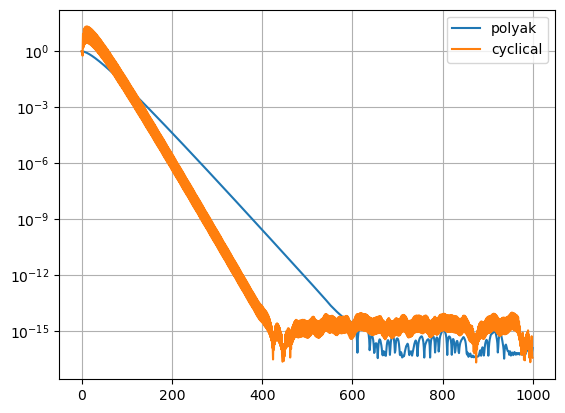

In [13]:
grad0 = norm_grad_polyak[0]
plt.plot(norm_grad_polyak / grad0, label="polyak")

plt.plot(norm_grad_cyclical / grad0, label="cyclical")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


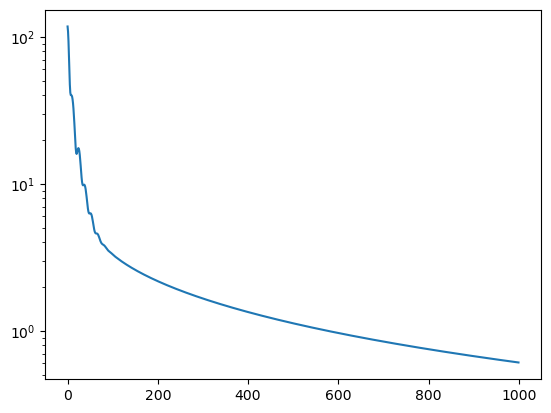

In [14]:
# reaload the dataset just in case
ds = tfds.load(name="mnist", split="train")
ds_numpy = tfds.as_numpy(ds)  # Convert `tf.data.Dataset` to Python generator
all_images = []
all_target = []
for ex in ds_numpy:
  # `{'image': np.array(shape=(28, 28, 1)), 'labels': np.array(shape=())}`
  all_images.append(ex['image'].ravel())
  all_target.append(ex['label'])

all_images = np.array(all_images).astype(np.float64)
all_target = np.array(all_target).astype(np.float64)



binary_target = all_target.copy().astype(np.int32)
binary_target[binary_target < 5] = 0
binary_target[binary_target > 4] = 1


H_logloss = hessian(logloss)(jnp.zeros(all_images.shape[1]), all_images, all_target, 0)
print(H_logloss)
L_logloss = np.linalg.eigvalsh(H_logloss).max()


H_star, xt = hessian_optimum(logloss, all_images, binary_target, L_logloss, 
                          l2reg_logistic, max_iter=1000)


In [15]:
xt = jnp.zeros(all_images.shape[1], dtype=jnp.float64)


eigs_H_star = np.linalg.eigvalsh(H_star)

L2_log = np.max(eigs_H_star)
mu1_log = np.min(eigs_H_star)

L1_log = eigs_H_star[-2]
mu2_log = L2_log - (L1_log - mu1_log)

print(L2_log, mu2_log, L1_log, mu1_log)

assert L2_log >= mu2_log >= L1_log >= mu1_log


plt.title("Eigenvalue Density MNIST\n (logistic loss) ")
plt.hist(eigs_H_star, 50)
plt.yscale("log")
plt.axvline(L1_log, color=palette[0], linestyle='--', lw=1)
plt.axvline(mu1_log, color=palette[1], linestyle='--', lw=1)
plt.axvline(L2_log, color=palette[2], linestyle='--', lw=1)
plt.axvline(mu2_log, color=palette[3], linestyle='--', lw=1)


plt.text(L1_log * 0.999, 700,'$L_1$', color=palette[0])
plt.text(mu2_log * 0.999, 700,'$\mu_2$', color=palette[1])
plt.text(L2_log * 0.999, 700,'$L_2$', color=palette[2])
plt.text(mu1_log * 0.999, 700,'$\mu_1$', color=palette[3])

265475.26130195346 233998.7508095089 31482.829043153557 6.318550708980499


Text(6.312232158271518, 700, '$\\mu_1$')

In [16]:

x_init = jnp.zeros(all_images.shape[1], dtype=jnp.float64)
for _ in range(100):
  x_init -= (1/L2_log) * grad(logloss)(x_init, all_images, binary_target, l2reg_logistic)


In [17]:

norm_grad_polyak_log = run_polyak(
    x_init.copy(),
    logloss, L2_log, mu1_log, all_images, binary_target,
    l2reg_logistic, 1000)


In [18]:

norm_grad_cyclical_log = run_cyclical(
    x_init,
    logloss, L1_log, L2_log, mu1_log,
    mu2_log, all_images, binary_target, l2reg_logistic, 1000)


265475.26130195346 233998.7508095089 31482.829043153557 6.318550708980499
31476.510492444577 31476.510492444562
R 0.7628610701784474


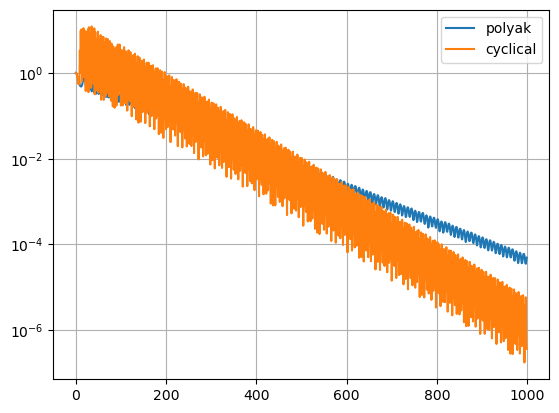

In [19]:
grad0 = norm_grad_polyak_log[0]
plt.plot(norm_grad_polyak_log / grad0, label="polyak")

plt.plot(norm_grad_cyclical_log / grad0, label="cyclical")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

# Simulations

In [20]:
np.random.seed(0)
n_samples = 3000
d = int(1.2 * n_samples)
x_tilde = (1 / np.sqrt(d)) * np.random.randn(d)
A = np.random.randn(n_samples, d)
Sigma = np.eye(d)
Sigma[:d // 1000] *= 10
A = A @ Sigma
b = A @ x_tilde


In [21]:
_H = jacfwd(jacrev(quadratic_loss))(np.zeros(d), A, b, 0.)
_eigs = np.linalg.eigvalsh(_H)
l2reg_sim1 = 1e-2 * np.max(_eigs)
H_sim1 = jacfwd(jacrev(quadratic_loss))(np.zeros(d), A, b, l2reg_sim1)

eigs_sim1 = np.linalg.eigvalsh(H_sim1)


94.96116348479757 5.444745877939871
109.06718295678758 94.96116348479757 15.18589257057205 1.0798730985820413


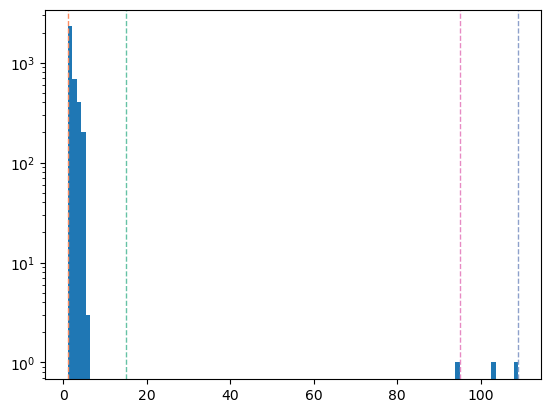

In [22]:
L2_sim1 = np.max(eigs_sim1)
mu1_sim1 = np.min(eigs_sim1)
print(eigs_sim1[-(d // 1000)], eigs_sim1[- (d // 1000 + 1)])

mu2_sim1 = eigs_sim1[- (d // 1000)]
L1_sim1 = L2_sim1 - mu2_sim1 + mu1_sim1

print(L2_sim1, mu2_sim1, L1_sim1, mu1_sim1)

plt.hist(eigs_sim1, 100)
plt.yscale("log")

plt.axvline(L1_sim1, color=palette[0], linestyle='--', lw=1)
plt.axvline(mu1_sim1, color=palette[1], linestyle='--', lw=1)
plt.axvline(L2_sim1, color=palette[2], linestyle='--', lw=1)
plt.axvline(mu2_sim1, color=palette[3], linestyle='--', lw=1)

plt.show()

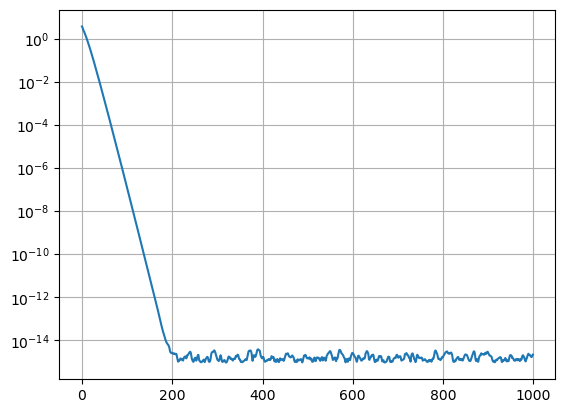

In [23]:
norm_grad_polyak_sim1 = run_polyak(
    jnp.zeros(A.shape[1], dtype=jnp.float64),
    quadratic_loss, np.max(eigs_sim1), np.min(eigs_sim1),
    A, b, l2reg_sim1, 1000)

plt.plot(norm_grad_polyak_sim1)
plt.grid()
plt.yscale("log")
plt.show()

109.06718295678758 94.96116348479757 15.18589257057205 1.0798730985820413
14.10601947199001 14.10601947199001
R 0.7387467195819186


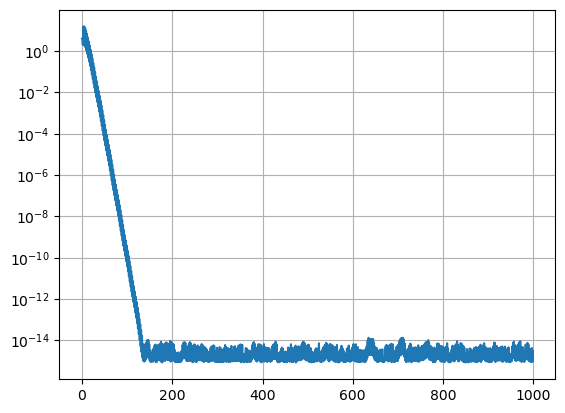

In [24]:
norm_grad_cyclical_sim1 = run_cyclical(
  jnp.zeros(A.shape[1], dtype=jnp.float64),
  quadratic_loss, L1_sim1, L2_sim1, mu1_sim1, mu2_sim1, A, b,
  l2reg_sim1, 1000)

plt.plot(norm_grad_cyclical_sim1)
plt.grid()
plt.yscale("log")
plt.show()

In [25]:
b_binary = (np.sign(b) + 1) // 2
_H = jacfwd(jacrev(logloss))(np.zeros(d), A, b_binary, 0.)
_eigs = np.linalg.eigvalsh(_H)
l2reg_sim2 = 1e-2 * np.max(_eigs)


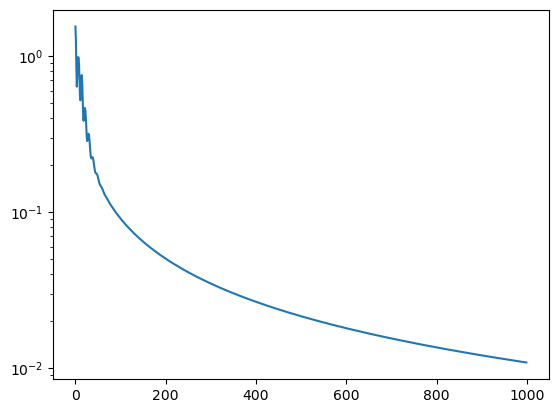

In [26]:

H2_star, xt2 = hessian_optimum(logloss, A, b_binary, L2_sim1, 
                          l2reg_sim2, max_iter=1000)


In [27]:

eigs_sim2 = np.linalg.eigvalsh(H2_star)

1.2366671189419804 1.0592592358945716 0.17755786542221175 0.00014998237480289768


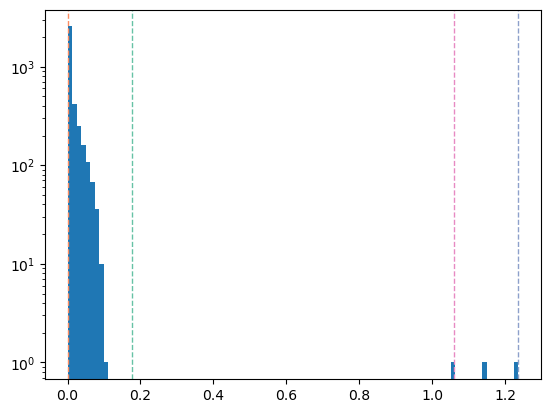

In [28]:
L2_sim2 = np.max(eigs_sim2)
mu1_sim2 = np.min(eigs_sim2)

mu2_sim2 = eigs_sim2[- (d // 1000)]
L1_sim2 = L2_sim2 - mu2_sim2 + mu1_sim2

print(L2_sim2, mu2_sim2, L1_sim2, mu1_sim2)

plt.hist(eigs_sim2, 100)
plt.yscale("log")

plt.axvline(L1_sim2, color=palette[0], linestyle='--', lw=1)
plt.axvline(mu1_sim2, color=palette[1], linestyle='--', lw=1)
plt.axvline(L2_sim2, color=palette[2], linestyle='--', lw=1)
plt.axvline(mu2_sim2, color=palette[3], linestyle='--', lw=1)

plt.show()

In [29]:
x_init2 = jnp.zeros(A.shape[1], dtype=jnp.float64)
for _ in range(500):
  x_init2 -= (1/L2_log) * grad(logloss)(x_init2, A, b_binary, l2reg_sim2)


In [30]:
norm_grad_polyak_sim2 = run_polyak(
    x_init2.copy(),
    logloss, np.max(eigs_sim2), np.min(eigs_sim2),
    A, b_binary, l2reg_sim2, 1000)


1.2366671189419804 1.0592592358945716 0.17755786542221175 0.00014998237480289768
0.17740788304740884 0.17740788304740884
R 0.7130522856481728


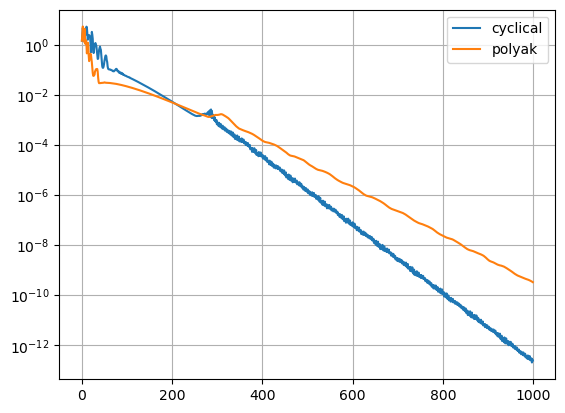

In [31]:
norm_grad_cyclical_sim2 = run_cyclical(
  x_init2.copy(),
  logloss, L1_sim2, L2_sim2, mu1_sim2, mu2_sim2, A, b_binary,
  l2reg_sim2, 1000)

plt.plot(norm_grad_cyclical_sim2, label="cyclical")
plt.plot(norm_grad_polyak_sim2, label="polyak")
plt.grid()
plt.legend()
plt.yscale("log")
plt.show()

# Plot the final figure

In [36]:

fig, axarr = plt.subplots(2, 4, figsize=(4 * 10, 2 * 8))

axarr[0, 0].set_title("Quadratic Loss (MNIST) ")
axarr[0, 0].hist(eigs/ L2, 50)
axarr[0, 0].set_yscale("log")
axarr[0, 0].axvline(L1 / L2, color='#4DAF4A', linestyle='--', lw=1)
axarr[0, 0].axvline(mu1/ L2, color='#984ea3', linestyle='--', lw=1)
axarr[0, 0].axvline(L2/ L2, color='#984ea3', linestyle='--', lw=1)
axarr[0, 0].axvline(mu2/ L2, color='#4DAF4A', linestyle='--', lw=1)


axarr[0, 0].text(L1 * 0.999/ L2, 400,'$L_1$', color='#4DAF4A')
axarr[0, 0].text(mu2 * 0.999/ L2, 400,'$\mu_2$', color='#4DAF4A')
axarr[0, 0].text(L2 * 0.999/ L2, 400,'$L_2$', color='#984ea3')
axarr[0, 0].text(mu1 * 0.999/ L2, 400,'$\mu_1$', color='#984ea3')
R = (mu2 - L1) / (L2 - mu1)
axarr[0, 0].text(0.7 * (mu1 / L2+ L2/ L2)/2, 10,'R=%.2f' % R, color="grey")

axarr[0, 0].set_ylabel("eigenvalue density")
axarr[0, 0].set_xlabel("eigenvalue magnitude")


axarr[0, 1].set_title("Logistic Loss (MNIST) ")
axarr[0, 1].hist(eigs_H_star / L2_log, 50)
axarr[0, 1].set_yscale("log")
axarr[0, 1].axvline(L1_log/ L2_log, color='#4DAF4A', linestyle='--', lw=1)
axarr[0, 1].axvline(mu1_log/ L2_log, color='#984ea3', linestyle='--', lw=1)
axarr[0, 1].axvline(L2_log/ L2_log, color='#984ea3', linestyle='--', lw=1)
axarr[0, 1].axvline(mu2_log/ L2_log, color='#4DAF4A', linestyle='--', lw=1)
R_log = (mu2_log - L1_log) / (L2_log - mu1_log)
axarr[0, 1].text(0.7 * (mu1_log / L2_log+ L2_log/ L2_log)/2, 10,'R=%.2f' % R_log, color="grey")


axarr[0, 1].text(L1_log * 0.999 / L2_log, 400,'$L_1$', color='#4DAF4A')
axarr[0, 1].text(mu2_log * 0.999/ L2_log, 400,'$\mu_2$', color='#4DAF4A')
axarr[0, 1].text(L2_log * 0.999/ L2_log, 400,'$L_2$', color='#984ea3')
axarr[0, 1].text(mu1_log * 0.999/ L2_log, 400,'$\mu_1$', color='#984ea3')

axarr[0, 1].set_xlabel("eigenvalue magnitude")


axarr[0, 2].set_title("Quadratic Loss (Synthetic)")
axarr[0, 2].hist(eigs_sim1 / L2_sim1, 50)
axarr[0, 2].set_yscale("log")
axarr[0, 2].axvline(L1_sim1/ L2_sim1, color='#4DAF4A', linestyle='--', lw=1)
axarr[0, 2].axvline(mu1_sim1/ L2_sim1, color='#984ea3', linestyle='--', lw=1)
axarr[0, 2].axvline(L2_sim1 / L2_sim1, color='#984ea3', linestyle='--', lw=1)
axarr[0, 2].axvline(mu2_sim1 / L2_sim1, color='#4DAF4A', linestyle='--', lw=1)


axarr[0, 2].text(L1_sim1 * 0.999 / L2_sim1, 700,'$L_1$', color='#4DAF4A')
axarr[0, 2].text(mu2_sim1 * 0.999 / L2_sim1, 700,'$\mu_2$', color='#4DAF4A')
axarr[0, 2].text(L2_sim1 * 0.999 / L2_sim1, 700,'$L_2$', color='#984ea3')
axarr[0, 2].text(mu1_sim1 * 0.999 / L2_sim1, 700,'$\mu_1$', color='#984ea3')
R_sim1 = (mu2_sim1 - L1_sim1) / (L2_sim1 - mu1_sim1)
axarr[0, 2].text(0.7 * (mu1_sim1 / L2_sim1+ L2_sim1/ L2_sim1)/2, 10,'R=%.2f' % R_sim1, color="grey")
axarr[0, 2].set_xlabel("eigenvalue magnitude")


axarr[0, 3].set_title("Logistic Loss (Synthetic)")
axarr[0, 3].hist(eigs_sim2 / L2_sim2, 50)
axarr[0, 3].set_yscale("log")
axarr[0, 3].axvline(L1_sim2 / L2_sim2, color='#4DAF4A', linestyle='--', lw=1)
axarr[0, 3].axvline(mu1_sim2/ L2_sim2, color='#984ea3', linestyle='--', lw=1)
axarr[0, 3].axvline(L2_sim2/ L2_sim2, color='#984ea3', linestyle='--', lw=1)
axarr[0, 3].axvline(mu2_sim2/ L2_sim2, color='#4DAF4A', linestyle='--', lw=1)

axarr[0, 3].text(L1_sim2 * 0.999/ L2_sim2, 700,'$L_1$', color='#4DAF4A')
axarr[0, 3].text(mu2_sim2 * 0.999/ L2_sim2, 700,'$\mu_2$', color='#4DAF4A')
axarr[0, 3].text(L2_sim2 * 0.999/ L2_sim2, 700,'$L_2$', color='#984ea3')
axarr[0, 3].text(mu1_sim2 * 0.999/ L2_sim2, 700,'$\mu_1$', color='#984ea3')

R_sim2 = (mu2_sim2 - L1_sim2) / (L2_sim2 - mu1_sim2)
axarr[0, 3].text(0.7 * (mu1_sim2 / L2_sim2+ L2_sim2/ L2_sim2)/2, 10,'R=%.2f' % R_sim2, color="grey")
axarr[0, 3].set_xlabel("eigenvalue magnitude")


#axarr[1, 0].set_title("Benchmarks MNIST \n (quadratic loss)")
axarr[1, 0].set_yscale("log")
axarr[1, 1].set_yscale("log")
axarr[1, 2].set_yscale("log")
axarr[1, 3].set_yscale("log")
axarr[1, 0].set_ylabel(r"|$\nabla$ f(x)|")
for i in range(4):
  axarr[1, i].set_xlabel("Iterations")
axarr[1, 0].plot(norm_grad_polyak / norm_grad_polyak[0], label="Polyak heavy ball", color=palette[0], marker="^", markevery=140, markersize=25, lw=3)
#axarr[1, 0].plot(norm_grad_gd, label="GD")
axarr[1, 0].plot(np.arange(0, len(norm_grad_cyclical), 2), 
                 norm_grad_cyclical[::2] / norm_grad_polyak[0], label="Cyclical heavy ball with optimal parameters (K=2)", color=palette[1], marker="s", markevery=60, markersize=25, lw=3)
axarr[1, 0].grid()
axarr[1, 0].set_xlim((0, 500))
axarr[1, 0].set_ylim((1e-12, None))


#axarr[1, 1].set_title("Benchmarks MNIST \n (logistic loss)")
axarr[1, 1].plot(norm_grad_polyak_log / norm_grad_polyak_log[0], label="Polyak heavy ball", color=palette[0], marker="^", markevery=140, markersize=25, lw=3)
axarr[1, 1].plot(np.arange(0, len(norm_grad_cyclical_log), 2), norm_grad_cyclical_log[::2] / norm_grad_polyak_log[0], label="Cyclical heavy ball with optimal parameters (K=2)",
                 color=palette[1], marker="s", markevery=120, markersize=25, lw=3)
axarr[1, 1].grid()
axarr[1, 1].set_xlim((0, 800))
axarr[1, 1].set_ylim((1e-12, None))


#axarr[1, 2].set_title("Benchmarks Synthetic \n (quadratic loss)")
axarr[1, 2].plot(norm_grad_polyak_sim1 / norm_grad_polyak_sim1[0], label="Polyak heavy ball", color=palette[0], marker="^", markevery=70, markersize=25, lw=3)
axarr[1, 2].plot(np.arange(0, len(norm_grad_cyclical_sim1), 2), norm_grad_cyclical_sim1[::2] / norm_grad_polyak_sim1[0], label="Cyclical heavy ball with optimal parameters (K=2)",
                 color=palette[1], marker="s", markevery=20, markersize=25, lw=3)
axarr[1, 2].grid()
axarr[1, 2].set_xlim((0, 150))
axarr[1, 2].set_ylim((1e-12, None))


#axarr[1, 3].set_title("Benchmarks Synthetic \n (logistic loss)")
axarr[1, 3].plot(norm_grad_polyak_sim2 / norm_grad_polyak_sim2[0], label="Polyak heavy ball", color=palette[0], marker="^", markevery=140, markersize=25, lw=3)
axarr[1, 3].plot(np.arange(0, len(norm_grad_cyclical_sim2), 2), norm_grad_cyclical_sim2[::2] / norm_grad_polyak_sim2[0],
                 label="Cyclical heavy ball with opimal parameters (K=2)", color=palette[1], marker="s", markevery=120, markersize=25, lw=3)
axarr[1, 3].grid()
axarr[1, 3].set_xlim((0, 1000))
axarr[1, 3].set_ylim((1e-12, None))


plt.tight_layout()
axarr[1, 0].legend(loc='upper left', bbox_to_anchor=(0.4, -0.2), ncol=5, frameon=False, fontsize=45)

f_path = '/tmp/benchmarks_cyclical.pdf'
fig.savefig(f_path, dpi=300, bbox_inches = 'tight', transparent=True)
%download_file {f_path}

plt.show()

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_cpu_pedregosa.kernel.pedregosa.1284891518897.14b334fb3717c109/mount/server/ml_notebook:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fc" which is no longer supported as of 3.3 and will become an error two minor releases later
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_cpu_pedregosa.kernel.pedregosa.1284891518897.14b334fb3717c109/mount/server/ml_notebook:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ec" which is no longer supported as of 3.3 and will become an error two minor releases later
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_cpu_pedregosa.kernel.pedregosa.1284891518897.14b334fb3717c109/mount/server/ml_notebook:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "shape" which is no longer supported as of 3.3 and will become an error two minor releases later


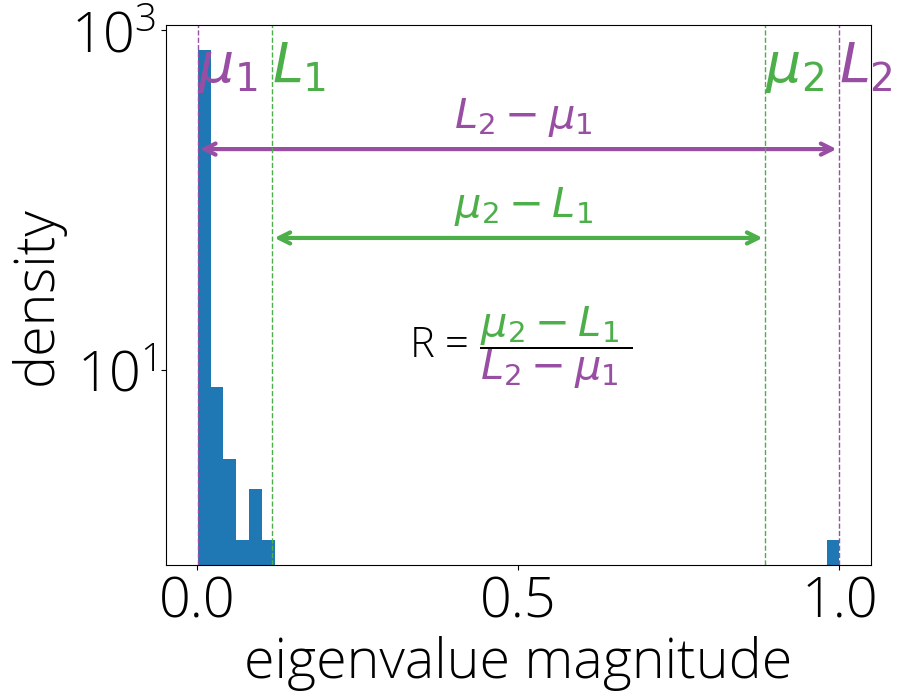

In [ ]:
palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854', '#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']


fig, axarr = plt.subplots(1, 1, figsize=(1 * 10, 1 * 8))

#axarr.set_title("Eigenvalue Density MNIST\n (quadratic loss) ")
axarr.hist(eigs / L2, 50)
axarr.set_yscale("log")
axarr.axvline(L1 / L2, color='#4DAF4A', linestyle='--', lw=1)
axarr.axvline(mu1 / L2, color=palette[8], linestyle='--', lw=1)
axarr.axvline(L2 / L2, color=palette[8], linestyle='--', lw=1)
axarr.axvline(mu2 / L2, color='#4DAF4A', linestyle='--', lw=1)


axarr.text(L1 * 0.999  / L2, 500,'$L_1$', color='#4DAF4A')
axarr.text(mu2 * 0.999  / L2, 500,'$\mu_2$', color='#4DAF4A')
axarr.text(L2 * 0.999 / L2, 500,'$L_2$', color=palette[8])
axarr.text(mu1 * 0.999 / L2, 500,'$\mu_1$', color=palette[8])

axarr.set_ylabel("density")
axarr.set_xlabel("eigenvalue magnitude")

import matplotlib.patches as patches

p1 = patches.FancyArrowPatch((0, 200), (1, 200), arrowstyle='<->',
                             mutation_scale=20, color=palette[8], linewidth=3)
axarr.add_patch(p1)
p2 = patches.FancyArrowPatch((L1 / L2, 60), (mu2 / L2, 60), arrowstyle='<->',
                             mutation_scale=20, color='#4DAF4A', linewidth=3)
axarr.add_patch(p2)
axarr.text(0.4, 270, r"$L_2 - \mu_1$", color=palette[8], fontsize=30)
axarr.text(0.4, 80, r"$\mu_2 - L_1$", color='#4DAF4A', fontsize=30)
axarr.text(0.33, 12, r"R = $\frac{~~~~~~~~~~~~~~~~}{~~~}$", color='k', fontsize=30)
axarr.text(0.44, 16, r"$\mu_2 - L_1$", color='#4DAF4A', fontsize=30)
axarr.text(0.44, 9, r"$L_2 - \mu_1$", color=palette[8], fontsize=30)

plt.tight_layout()

f_path = '/tmp/spectrum_mnist.pdf'
fig.savefig(f_path, dpi=300, bbox_inches = 'tight', transparent=True, fc='k', ec='k',
            shape="full")
%download_file {f_path}

plt.show()



In [ ]:
print(palette[8])

#984ea3
